<h1 style="text-align: center;">DATA 255 - Fall24 - Group Project</h1>

<h2 style="text-align: center;"> Pneumonia Detection using chest X-Ray and Deep Learning Technologies

## 1. Importing necessary libraries

In [1]:
import os
import torch
import torch.nn as nn
from torchvision import models
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
import shutil
import random
from torchvision import datasets
from PIL import Image
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.metrics import roc_curve, auc
from torch.utils.data import TensorDataset
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from torchinfo import summary
import pandas as pd
import seaborn as sns
from tqdm import tqdm

## 2. Loading and Exploring the data

#### <b> 2.1. Importing train, Validation and test Dataset, and exploring the classes of images

In [2]:
# Define the base directory directly to the dataset path
base_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray"
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Resize to 150x150
    transforms.ToTensor(),         # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to range [-1, 1]
])

# Load the datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Class mappings (optional, to verify classes)
class_names = train_dataset.classes
print("Class Names:", class_names)

Class Names: ['NORMAL', 'PNEUMONIA']


#### <b> 2.2. How many images present in the train, Validation and test Dataset

In [3]:
# Count images in each dataset
train_total = len(train_dataset)
val_total = len(val_dataset)
test_total = len(test_dataset)

# Calculate ratios
total_images = train_total + val_total + test_total
train_ratio = train_total / total_images
val_ratio = val_total / total_images
test_ratio = test_total / total_images

# Print results
print(f"Total Images: {total_images}")
print(f"Training Set: {train_total} images ({train_ratio:.2%} of total)")
print(f"Validation Set: {val_total} images ({val_ratio:.2%} of total)")
print(f"Test Set: {test_total} images ({test_ratio:.2%} of total)")

Total Images: 5856
Training Set: 5216 images (89.07% of total)
Validation Set: 16 images (0.27% of total)
Test Set: 624 images (10.66% of total)


#### Validation Set: Contains only 16 images, accounting for just 0.27% of the total dataset. This is unusually small for a validation set, which might lead to unreliable performance evaluation during training.

#### Here we see that the dataset split is not proper

#### <b> 2.3. Visually showing how many images present in the train, Validation and test Dataset

Train Class Distribution: {'NORMAL': 1341, 'PNEUMONIA': 3875}
Validation Class Distribution: {'NORMAL': 8, 'PNEUMONIA': 8}
Test Class Distribution: {'NORMAL': 234, 'PNEUMONIA': 390}


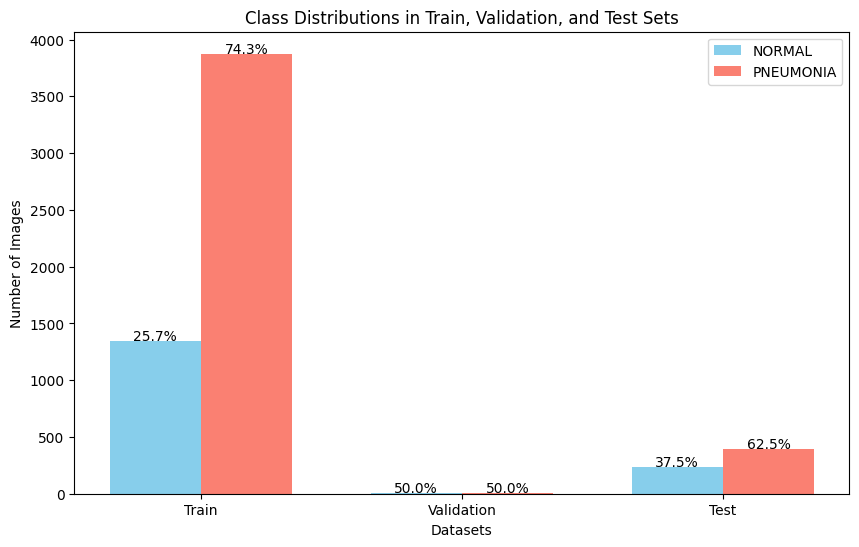

In [4]:
# Count images for each class
def count_images_per_class(dataset):
    class_counts = {class_name: 0 for class_name in dataset.classes}
    for _, label in dataset:
        class_name = dataset.classes[label]
        class_counts[class_name] += 1
    return class_counts

# Get class distributions
train_counts = count_images_per_class(train_dataset)
val_counts = count_images_per_class(val_dataset)
test_counts = count_images_per_class(test_dataset)

# Print distributions
print("Train Class Distribution:", train_counts)
print("Validation Class Distribution:", val_counts)
print("Test Class Distribution:", test_counts)

# Visualization
datasets_names = ['Train', 'Validation', 'Test']
class_labels = train_dataset.classes  # Classes from ImageFolder

# Prepare data for plotting
data = [
    [train_counts[class_labels[0]], train_counts[class_labels[1]]],
    [val_counts[class_labels[0]], val_counts[class_labels[1]]],
    [test_counts[class_labels[0]], test_counts[class_labels[1]]],
]

# Calculate total images in each dataset
totals = [sum(d) for d in data]

# Plot bar chart
x = range(len(datasets_names))
bar_width = 0.35

plt.figure(figsize=(10, 6))
bars1 = plt.bar(x, [d[0] for d in data], width=bar_width, label=class_labels[0], color='skyblue')
bars2 = plt.bar([i + bar_width for i in x], [d[1] for d in data], width=bar_width, label=class_labels[1], color='salmon')

# Add percentage labels on top of the bars
for i, bars in enumerate([bars1, bars2]):  # Loop through NORMAL and PNEUMONIA bars
    for bar, count in zip(bars, [d[i] for d in data]):
        percent = (count / totals[bars.index(bar)]) * 100  # Calculate percentage
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, f'{percent:.1f}%', 
                 ha='center', fontsize=10)

# Add labels and title
plt.xlabel('Datasets')
plt.ylabel('Number of Images')
plt.title('Class Distributions in Train, Validation, and Test Sets')
plt.xticks([i + bar_width / 2 for i in x], datasets_names)
plt.legend()
plt.show()

### Here we see that the Classes are balanced only in validation dataset but highly imbalanced in Train and Test dataset. However, the small size of the validation set makes it unreliable for evaluating class-specific performance or overall validation accuracy.

### Training Set: The PNEUMONIA class has significantly more samples (3875) than the NORMAL class (1341). This imbalance may cause the model to become biased toward predicting PNEUMONIA more often, leading to poor generalization for the NORMAL class

## 3. Preprocessing the Data 

#### <b> 3.1. Data Redistribution for Chest X-Ray Pneumonia Dataset

In [5]:
# Paths to original directories
train_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
val_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'

# New directories for redistributed data
base_dir = '/kaggle/working/chest_xray_redistributed'
train_new_dir = os.path.join(base_dir, 'train')
val_new_dir = os.path.join(base_dir, 'val')
test_new_dir = os.path.join(base_dir, 'test')

# Create new directories
os.makedirs(train_new_dir, exist_ok=True)
os.makedirs(val_new_dir, exist_ok=True)
os.makedirs(test_new_dir, exist_ok=True)

for cls in ['NORMAL', 'PNEUMONIA']:
    os.makedirs(os.path.join(train_new_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_new_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_new_dir, cls), exist_ok=True)

# Function to gather all images in a directory structure
def get_all_images(directory, class_name):
    full_path = os.path.join(directory, class_name)
    return [os.path.join(full_path, fname) for fname in os.listdir(full_path) if fname.endswith(('.png', '.jpg', '.jpeg'))]

# Gather images from the original directories
all_normal = get_all_images(train_dir, 'NORMAL') + get_all_images(val_dir, 'NORMAL') + get_all_images(test_dir, 'NORMAL')
all_pneumonia = get_all_images(train_dir, 'PNEUMONIA') + get_all_images(val_dir, 'PNEUMONIA') + get_all_images(test_dir, 'PNEUMONIA')

# Shuffle images for random distribution
random.shuffle(all_normal)
random.shuffle(all_pneumonia)

# Function to split data into train, validation, and test sets
def split_data(data, train_ratio, val_ratio):
    train_split = int(len(data) * train_ratio)
    val_split = int(len(data) * (train_ratio + val_ratio))
    return data[:train_split], data[train_split:val_split], data[val_split:]

# Split the data
train_normal, val_normal, test_normal = split_data(all_normal, 0.7, 0.15)
train_pneumonia, val_pneumonia, test_pneumonia = split_data(all_pneumonia, 0.7, 0.15)

# Function to copy files to target directory
def copy_files(file_list, target_dir):
    for file_path in file_list:
        shutil.copy(file_path, target_dir)

# Copy files to new directories
copy_files(train_normal, os.path.join(train_new_dir, 'NORMAL'))
copy_files(val_normal, os.path.join(val_new_dir, 'NORMAL'))
copy_files(test_normal, os.path.join(test_new_dir, 'NORMAL'))

copy_files(train_pneumonia, os.path.join(train_new_dir, 'PNEUMONIA'))
copy_files(val_pneumonia, os.path.join(val_new_dir, 'PNEUMONIA'))
copy_files(test_pneumonia, os.path.join(test_new_dir, 'PNEUMONIA'))

print("Data redistribution complete!")

Data redistribution complete!


#### <b> 3.2. Analyzing Redistributed Datasets

In [6]:
# Paths to redistributed data directories
redistributed_train_dir = '/kaggle/input/chest-xray-redistributed/chest_xray_redistributed/train'
redistributed_val_dir = '/kaggle/input/chest-xray-redistributed/chest_xray_redistributed/val'
redistributed_test_dir = '/kaggle/input/chest-xray-redistributed/chest_xray_redistributed/test'

# Function to count images per class
def count_images_per_class(directory):
    dataset = datasets.ImageFolder(directory)
    class_counts = {class_name: 0 for class_name in dataset.classes}
    for _, label in dataset:
        class_name = dataset.classes[label]
        class_counts[class_name] += 1
    return class_counts

# Count images in redistributed datasets
redistributed_train_counts = count_images_per_class(redistributed_train_dir)
redistributed_val_counts = count_images_per_class(redistributed_val_dir)
redistributed_test_counts = count_images_per_class(redistributed_test_dir)

# Total images in redistributed datasets
total_images_redistributed = (
    sum(redistributed_train_counts.values()) +
    sum(redistributed_val_counts.values()) +
    sum(redistributed_test_counts.values())
)

# Calculate ratios
train_ratio_redistributed = sum(redistributed_train_counts.values()) / total_images_redistributed * 100
val_ratio_redistributed = sum(redistributed_val_counts.values()) / total_images_redistributed * 100
test_ratio_redistributed = sum(redistributed_test_counts.values()) / total_images_redistributed * 100

# Print ratios
print("Redistributed Data Ratios:")
print(f"Training Set: {sum(redistributed_train_counts.values())} images ({train_ratio_redistributed:.2f}% of total)")
print(f"Validation Set: {sum(redistributed_val_counts.values())} images ({val_ratio_redistributed:.2f}% of total)")
print(f"Test Set: {sum(redistributed_test_counts.values())} images ({test_ratio_redistributed:.2f}% of total)")

# Print class-wise distributions
print("\nClass-wise Distributions:")
print(f"Train Class Distribution: {redistributed_train_counts}")
print(f"Validation Class Distribution: {redistributed_val_counts}")
print(f"Test Class Distribution: {redistributed_test_counts}")

Redistributed Data Ratios:
Training Set: 4099 images (70.00% of total)
Validation Set: 878 images (14.99% of total)
Test Set: 879 images (15.01% of total)

Class-wise Distributions:
Train Class Distribution: {'NORMAL': 1108, 'PNEUMONIA': 2991}
Validation Class Distribution: {'NORMAL': 237, 'PNEUMONIA': 641}
Test Class Distribution: {'NORMAL': 238, 'PNEUMONIA': 641}


### You want to avoid the possibility of overfitting by using a too-small validation set. By allocating 15% for both validation and test sets, you ensure that both the validation and test sets are sufficiently large and representative of the entire dataset

### With 80:10:10 split, the model might overfit on the training set since the validation set is too small to give meaningful feedback

#### <b> 3.3. Visually showing how many images present in the train, Validation and test Redistributed Dataset

Train Class Distribution: {'NORMAL': 1108, 'PNEUMONIA': 2991}
Validation Class Distribution: {'NORMAL': 237, 'PNEUMONIA': 641}
Test Class Distribution: {'NORMAL': 238, 'PNEUMONIA': 641}


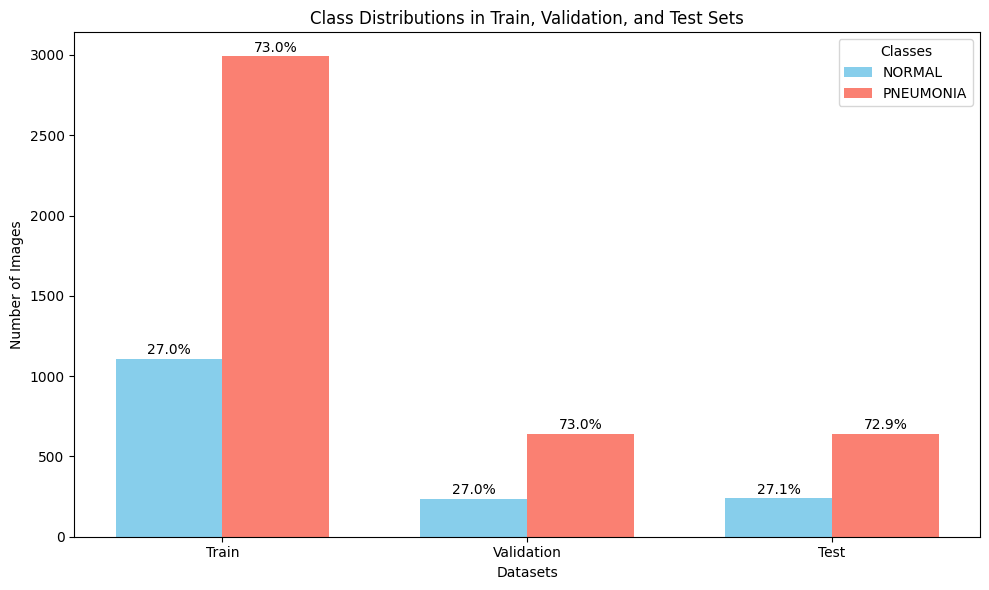

In [7]:
# Function to count images per class using PyTorch ImageFolder
def count_images_per_class(directory):
    dataset = datasets.ImageFolder(directory)
    class_counts = {class_name: 0 for class_name in dataset.classes}
    for _, label in dataset:
        class_name = dataset.classes[label]
        class_counts[class_name] += 1
    return class_counts

# Count images in redistributed datasets
redistributed_train_counts = count_images_per_class(redistributed_train_dir)
redistributed_val_counts = count_images_per_class(redistributed_val_dir)
redistributed_test_counts = count_images_per_class(redistributed_test_dir)

# Print class distributions
print("Train Class Distribution:", redistributed_train_counts)
print("Validation Class Distribution:", redistributed_val_counts)
print("Test Class Distribution:", redistributed_test_counts)

# Visualization
datasets = ['Train', 'Validation', 'Test']
class_labels = list(redistributed_train_counts.keys())  # Dynamically get class labels

# Prepare data for plotting
data = [
    [redistributed_train_counts[class_labels[0]], redistributed_train_counts[class_labels[1]]],
    [redistributed_val_counts[class_labels[0]], redistributed_val_counts[class_labels[1]]],
    [redistributed_test_counts[class_labels[0]], redistributed_test_counts[class_labels[1]]],
]

# Plot bar chart
x = range(len(datasets))
bar_width = 0.35

plt.figure(figsize=(10, 6))
bars1 = plt.bar(x, [d[0] for d in data], width=bar_width, label=class_labels[0], color='skyblue')
bars2 = plt.bar([i + bar_width for i in x], [d[1] for d in data], width=bar_width, label=class_labels[1], color='salmon')

# Add percentage labels on top of the bars
totals = [sum(d) for d in data]
for i, bars in enumerate([bars1, bars2]):  # Loop through class-wise bars
    for bar, count in zip(bars, [d[i] for d in data]):
        percent = (count / totals[bars.index(bar)]) * 100  # Calculate percentage
        # Place percentage labels clearly above the bars
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 10, f'{percent:.1f}%',
                 ha='center', fontsize=10, color='black', va='bottom')

# Add labels and title
plt.xlabel('Datasets')
plt.ylabel('Number of Images')
plt.title('Class Distributions in Train, Validation, and Test Sets')
plt.xticks([i + bar_width / 2 for i in x], datasets)
plt.legend(title="Classes")
plt.tight_layout()
plt.show()

## 4. Basic Data Exploration

#### <b> 4.1. Displaying Sample Images from Redistributed Dataset

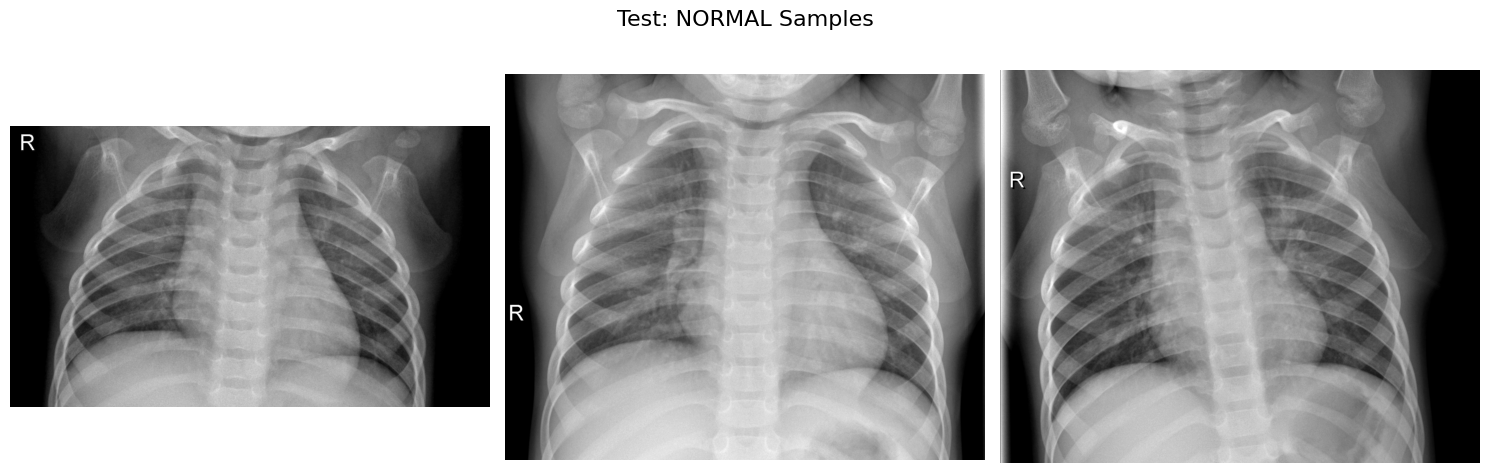

In [8]:
# Function to get image file paths from a specific class
def get_sample_images(directory, class_name, num_samples=3):
    class_dir = os.path.join(directory, class_name)
    image_files = os.listdir(class_dir)
    sample_files = image_files[:num_samples]  # Take the first few images
    return [os.path.join(class_dir, file) for file in sample_files]

# Get samples from train and test datasets
train_normal_samples = get_sample_images(redistributed_train_dir, 'NORMAL', 3)
train_pneumonia_samples = get_sample_images(redistributed_train_dir, 'PNEUMONIA', 3)
test_normal_samples = get_sample_images(redistributed_test_dir, 'NORMAL', 3)
test_pneumonia_samples = get_sample_images(redistributed_test_dir, 'PNEUMONIA', 3)

# Function to display images
def display_images(image_paths, title, rows=1, cols=3):
    plt.figure(figsize=(15, 5))
    for i, image_path in enumerate(image_paths):
        img = Image.open(image_path)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Display samples
display_images(train_normal_samples, "Train: NORMAL Samples")
display_images(train_pneumonia_samples, "Train: PNEUMONIA Samples")
display_images(test_normal_samples, "Test: NORMAL Samples")
display_images(test_pneumonia_samples, "Test: PNEUMONIA Samples")

#### <b> 4.2. Calculating Average Image Sizes for Dataset Classes

In [9]:
# Function to calculate average image sizes for classes
def get_image_sizes(directory):
    sizes = {}
    for cls in ['NORMAL', 'PNEUMONIA']:
        class_dir = os.path.join(directory, cls)
        image_sizes = []
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            with Image.open(img_path) as img:  # Open the image using PIL
                img_size = img.size  # Returns (width, height)
                image_sizes.append(img_size)
        
        # Calculate the average width and height for the class
        avg_width = sum([size[0] for size in image_sizes]) // len(image_sizes)
        avg_height = sum([size[1] for size in image_sizes]) // len(image_sizes)
        sizes[cls] = (avg_width, avg_height)
    return sizes


# Get average image sizes for each dataset
redistributed_train_sizes = get_image_sizes(redistributed_train_dir)
redistributed_val_sizes = get_image_sizes(redistributed_val_dir)
redistributed_test_sizes = get_image_sizes(redistributed_test_dir)

# Print average image sizes for each dataset
print("Average Image Sizes for Train, Validation, and Test Sets:")
print(f"Training Set - NORMAL: {redistributed_train_sizes['NORMAL']}, PNEUMONIA: {redistributed_train_sizes['PNEUMONIA']}")
print(f"Validation Set - NORMAL: {redistributed_val_sizes['NORMAL']}, PNEUMONIA: {redistributed_val_sizes['PNEUMONIA']}")
print(f"Test Set - NORMAL: {redistributed_test_sizes['NORMAL']}, PNEUMONIA: {redistributed_test_sizes['PNEUMONIA']}")

Average Image Sizes for Train, Validation, and Test Sets:
Training Set - NORMAL: (1691, 1385), PNEUMONIA: (1194, 819)
Validation Set - NORMAL: (1684, 1380), PNEUMONIA: (1190, 808)
Test Set - NORMAL: (1662, 1343), PNEUMONIA: (1203, 831)


#### <b> 4.3. Analyzing Pixel Intensity Distribution for Dataset Classes

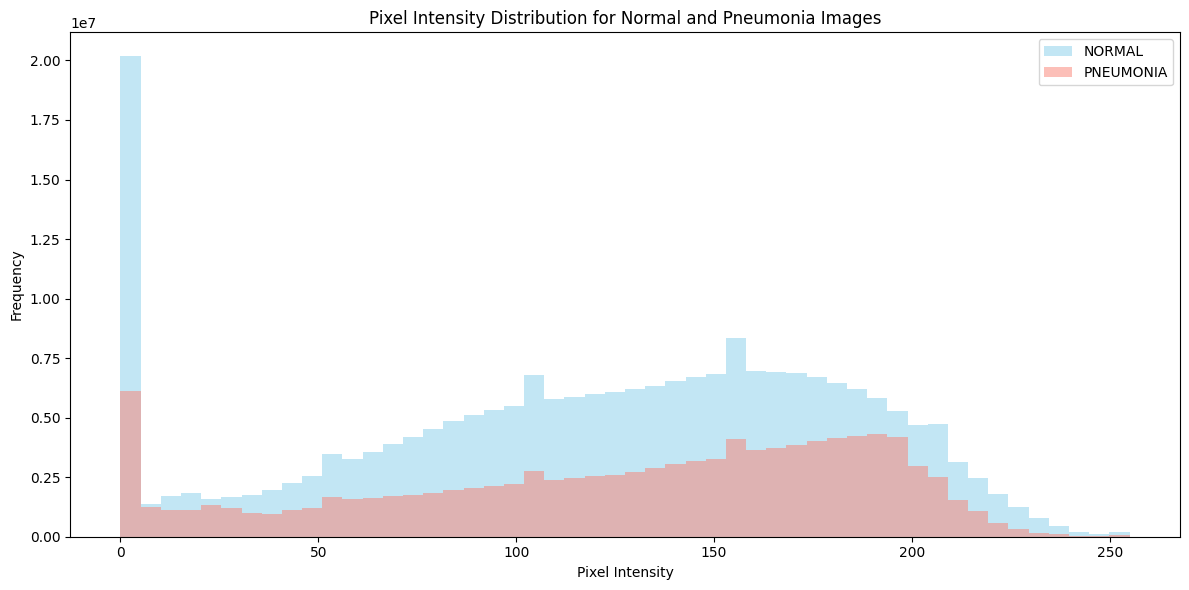

In [10]:
# Function to extract pixel data from sample images
def extract_pixel_data(directory, class_name, sample_size=100):
    class_dir = os.path.join(directory, class_name)
    image_paths = [os.path.join(class_dir, fname) for fname in os.listdir(class_dir)]
    pixel_values = []
    
    for img_path in image_paths[:sample_size]:  # Take a subset of images
        with Image.open(img_path) as img:
            img = img.convert('L')  # Convert to grayscale for simplicity
            img_array = np.array(img)  # Convert to numpy array
            pixel_values.append(img_array.flatten())  # Flatten the array into 1D
        
    return np.concatenate(pixel_values)  # Concatenate all pixel values

# Extract pixel data for Normal and Pneumonia
normal_pixel_data = extract_pixel_data(redistributed_train_dir, 'NORMAL')
pneumonia_pixel_data = extract_pixel_data(redistributed_train_dir, 'PNEUMONIA')

# Plot the histograms of pixel values
plt.figure(figsize=(12, 6))

# Plot histogram for NORMAL class
plt.hist(normal_pixel_data, bins=50, alpha=0.5, label='NORMAL', color='skyblue')

# Plot histogram for PNEUMONIA class
plt.hist(pneumonia_pixel_data, bins=50, alpha=0.5, label='PNEUMONIA', color='salmon')

# Adding labels and title
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Pixel Intensity Distribution for Normal and Pneumonia Images')
plt.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()

### we will extract pixel values from a few sample images from each class, then plot their pixel intensity distributions.. The histograms represent the distribution of pixel intensities across the images in each class. A higher intensity (closer to 255) indicates a brighter pixel, while lower values (closer to 0) represent darker pixels.

### The NORMAL images have a sharp peak in the lower pixel intensity range (around 0–50), which suggests that most of the pixels in these images are very dark (low intensity). This likely reflects the air in the lungs, which appears black in X-ray images. The distribution also shows some pixels with higher intensities (shifting toward the 100–150 range), which could correspond to bones, tissues, and other structures that are slightly brighter than air.

### The PNEUMONIA images have a broader distribution, with higher frequencies in the mid to higher pixel intensity range (around 50–150). This indicates that there are more variations in pixel intensity in PNEUMONIA images. This suggests that PNEUMONIA images often contain more areas of consolidation, infection, or inflammation, which may appear lighter (higher pixel intensity) than healthy lung tissue (air).

### There's significant overlap in pixel intensity distributions between the two classes, indicating that there is some similarity in pixel values, but the PNEUMONIA distribution tends to shift toward higher pixel intensities overall, likely due to the presence of inflammation and infection within the lungs.

### The class imbalance is apparent, with the "PNEUMONIA" class being the dominant one.¶

### 3 methods to correct class imbalance:
- ** Over sample under sample **- Cannot over or under sample because we have image data. (SMOTE- synthetic minority over sampling technique)
- Assigning Class weights (Class Weights ensure that the minority class is not ignored by the model. It assigns higher importance to the underrepresented class by adjusting the loss function to penalize incorrect predictions on the minority class more heavily.)
- Data Augmentation- Applying data augmentation techniques (such as rotations, flips, shifts, etc.) can help to increase the size of the minority class while maintaining diversity in the data. In the context of chest X-ray images might not be ideal. Applying random transformations (e.g., rotation, zoom, flipping) to the "PNEUMONIA" class might alter the essential features that help identify pneumonia, leading to potentially unrealistic or misleading data. For instance, rotating or flipping a pneumonia image might change its appearance in a way that does not reflect real-life variations of pneumonia.

### we apply the class weights during modelling.

### Data Transformation:
Normalization (or rescaling) should be applied before data augmentation. The reason is that normalization ensures your pixel values are on a consistent scale, which is crucial for model convergence. Neural networks typically perform better when input data is normalized. Normalizing pixel values to a range of [0, 1] ensures the data fed into the model has consistent scales, making training easier and faster.
### 

Data Augmentat: ion
Data augmentation should be applied after normalization. The reason is that augmentation applies transformations to the image, and it's better to apply these transformations to already normalized images so that the augmented data also follows the same format as the original data. Augmentation artificially increases the diversity of your training data by applying various transformations (rotation, flip, zoom, etc.), helping your model generalize better. Augmentation can help improve the model's performance by creating more diverse samples for the minority class.

For training data, we use data augmentation parameters such as rotation, zoom, shifts, and flips, to artificially increase the diversity of the training dataset. The images are also normalized by scaling the pixel values to the range [0, 1] using rescale=1.0/255.0. For validation and test data, we only apply normalization (rescale=1.0/255.0) since we don’t want to augment these sets.

## 5. Data Transformation and Augmentation

#### <b> 5.1. Data Augmentation and DataLoader Setup for Training, Validation, and Testing

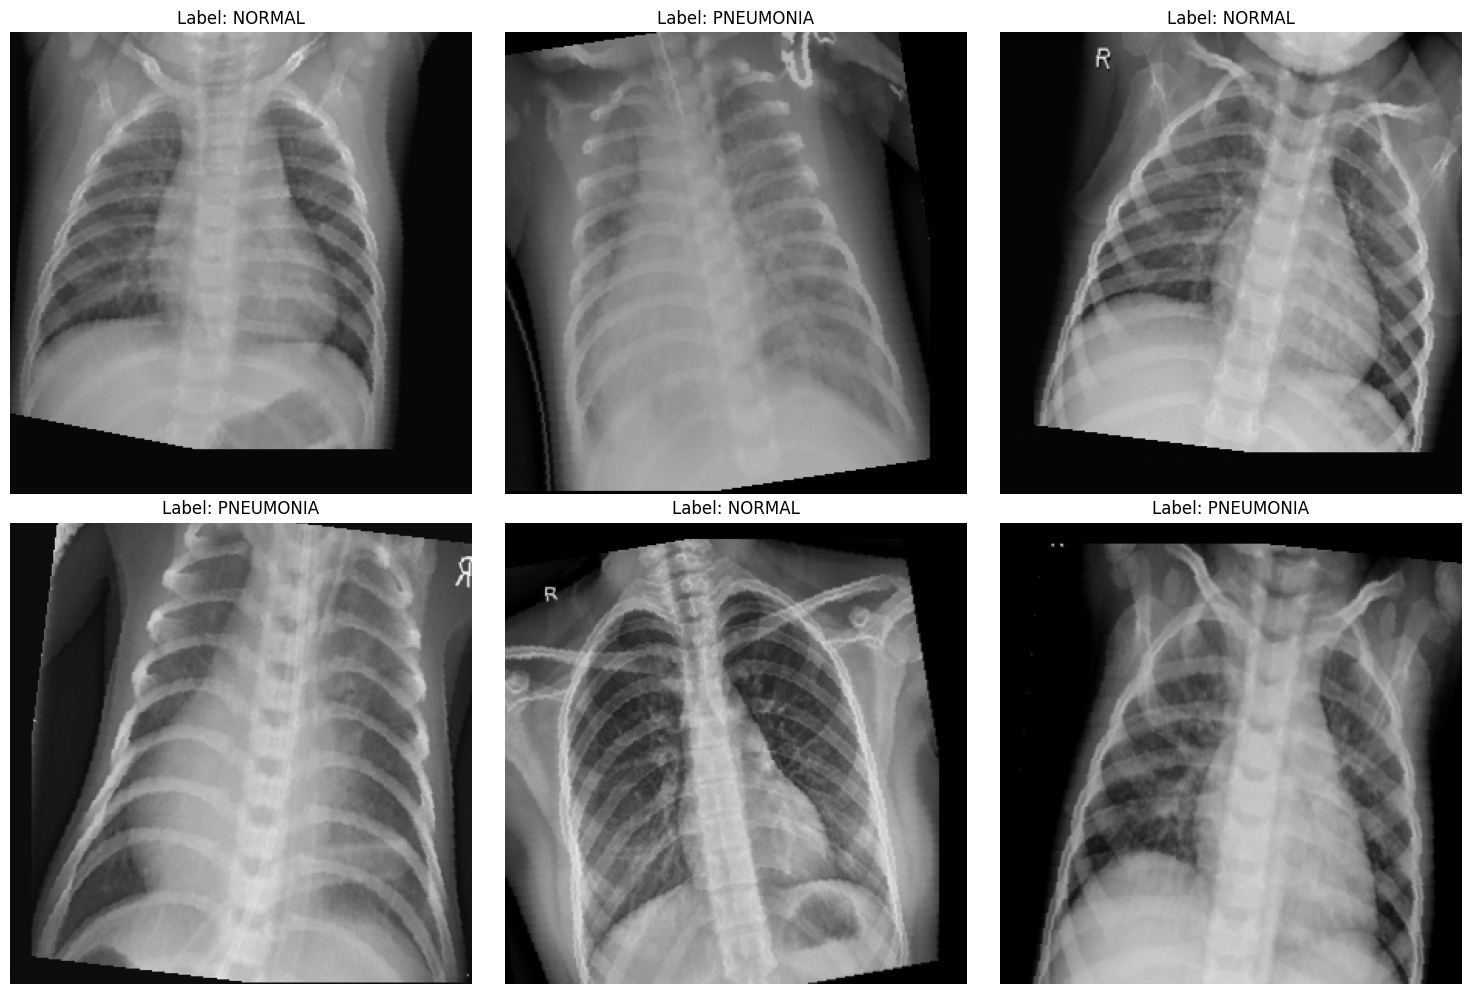

In [11]:
import os
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Training transforms with augmentation
train_transforms = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize for InceptionV3
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225])  # ImageNet stats
])

# Validation/Test transforms without augmentation
val_test_transforms = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize for InceptionV3
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225])  # ImageNet stats
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Convert 1-channel grayscale to 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization for ImageNet models
])

# Load datasets
train_dataset = datasets.ImageFolder(root=redistributed_train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=redistributed_val_dir, transform=val_test_transforms)
test_dataset = datasets.ImageFolder(root=redistributed_test_dir, transform=test_transform)

# Create data loaders with num_workers for faster loading
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

def display_augmented_images(data_loader, class_names, num_images=6):
    images, labels = next(iter(data_loader))
    
    # Denormalize images
    mean = torch.tensor([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).reshape(1, 3, 1, 1)
    images = images * std + mean
    
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        ax = plt.subplot(2, 3, i + 1)
        img = images[i].permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)  # Ensure values are in valid range
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(f"Label: {class_names[labels[i]]}")
    plt.tight_layout()
    plt.show()

# Class names for the labels
class_names = train_dataset.classes

# Display augmented images from the training set
display_augmented_images(train_loader, class_names, num_images=6)

#### <b> 5.2.1 Checking Image Dimensions After Transformations (train_loader)

In [12]:
# Function to print image dimensions after transformation (Resizing, etc.)
def print_image_dimensions_after_transformation(data_loader):
    # Get a batch of transformed images
    images, _ = next(iter(data_loader))

    # Print the shape of the images in the batch (C x H x W)
    print(f"Shape of one batch of images: {images.shape}")
    print(f"Number of images in the batch: {images.shape[0]}")
    print(f"Image dimensions (C x H x W): {images.shape[1]} x {images.shape[2]} x {images.shape[3]}")

# Print dimensions of the images after transformation for the training set
print_image_dimensions_after_transformation(train_loader)

Shape of one batch of images: torch.Size([32, 3, 299, 299])
Number of images in the batch: 32
Image dimensions (C x H x W): 3 x 299 x 299


### 150x150 is often chosen because it provides a good balance between computational efficiency and retaining meaningful information in the images. 150x150 is a moderate choice for many models, balancing both speed and accuracy.

### Smaller sizes (e.g., 64x64, 128x128) would reduce the number of pixels and might miss some important details, especially in medical imaging, where textures and patterns could be crucial for classification.

### Larger sizes (e.g., 224x224, 256x256) might retain more details, but they require more memory and computational power, slowing down the training process and potentially leading to overfitting if not managed properly.¶

#### <b> 5.2.2 Checking Image Dimensions After Transformations (test_loader)

In [13]:
# Print dimensions of the images after transformation for the training set
print_image_dimensions_after_transformation(test_loader)

Shape of one batch of images: torch.Size([32, 3, 224, 224])
Number of images in the batch: 32
Image dimensions (C x H x W): 3 x 224 x 224


#### <b> 5.2.3 Checking Image Dimensions After Transformations (val_loader)

In [14]:
# Print dimensions of the images after transformation for the training set
print_image_dimensions_after_transformation(val_loader)

Shape of one batch of images: torch.Size([32, 3, 299, 299])
Number of images in the batch: 32
Image dimensions (C x H x W): 3 x 299 x 299


#### <b> 5.3. Calculating Class Weights for Imbalanced Dataset

In [15]:
# Calculate class weights for the imbalance
class_counts = {'NORMAL': 1108, 'PNEUMONIA': 2991}  # Train class distribution
class_labels = ['NORMAL', 'PNEUMONIA']

# Compute class weights using sklearn's compute_class_weight method
class_weights = compute_class_weight(class_weight='balanced', classes=[0, 1], y=np.array([0] * class_counts['NORMAL'] + [1] * class_counts['PNEUMONIA']))
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).cuda()

# Print out the class weights
print(f"Class weights: {class_weights_tensor}")

Class weights: tensor([1.8497, 0.6852], device='cuda:0')


## 6. CheXNet model implementation

#### <b> 6.1 CheXNet Model

In [16]:
class CheXNet(nn.Module):
    def __init__(self, num_classes=2):
        super(CheXNet, self).__init__()
        
        # Load pre-trained DenseNet121 model
        self.model = models.densenet121(pretrained=True)
        
        # Modify the classifier to fit our number of classes (2: Normal, Pneumonia)
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(in_features, num_classes)
        
        # Disable inplace=True in all ReLU layers
        for module in self.model.modules():
            if isinstance(module, nn.ReLU):
                module.inplace = False  # Turn off inplace behavior
                
    def forward(self, x):
        return self.model(x)

In [17]:
# Instantiate the model
model = CheXNet(num_classes=2).cuda()

# Loss function (CrossEntropyLoss with class weights)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 140MB/s] 


#### <b> 6.2 Training

In [18]:
# Early stopping parameters
patience = 5  # Number of epochs with no improvement after which training will stop
best_val_loss = float('inf')
epochs_without_improvement = 0
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Training phase
    for inputs, labels in train_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = running_val_loss / len(val_loader)
    val_accuracy = val_correct / val_total

    # Track the losses and accuracies for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Early stopping after {epoch+1} epochs")
            break

    # Print training and validation loss/accuracy
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

Epoch [1/50], Train Loss: 0.1835, Train Accuracy: 0.9371, Val Loss: 0.1201, Val Accuracy: 0.9544
Epoch [2/50], Train Loss: 0.1113, Train Accuracy: 0.9602, Val Loss: 0.1130, Val Accuracy: 0.9624
Epoch [3/50], Train Loss: 0.0948, Train Accuracy: 0.9663, Val Loss: 0.0877, Val Accuracy: 0.9727
Epoch [4/50], Train Loss: 0.0821, Train Accuracy: 0.9732, Val Loss: 0.1252, Val Accuracy: 0.9487
Epoch [5/50], Train Loss: 0.0730, Train Accuracy: 0.9739, Val Loss: 0.0621, Val Accuracy: 0.9761
Epoch [6/50], Train Loss: 0.0700, Train Accuracy: 0.9758, Val Loss: 0.0621, Val Accuracy: 0.9841
Epoch [7/50], Train Loss: 0.0585, Train Accuracy: 0.9819, Val Loss: 0.0900, Val Accuracy: 0.9658
Epoch [8/50], Train Loss: 0.0544, Train Accuracy: 0.9800, Val Loss: 0.1477, Val Accuracy: 0.9453
Epoch [9/50], Train Loss: 0.0476, Train Accuracy: 0.9837, Val Loss: 0.1282, Val Accuracy: 0.9522
Early stopping after 10 epochs


#### <b> 6.3 Loading and Saving the Final Best Model

In [19]:
# Save the model weights
model_save_path = '/kaggle/working/chexnet_model.pth'
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to /kaggle/working/chexnet_model.pth


#### <b> 6.4 Plotting Training History

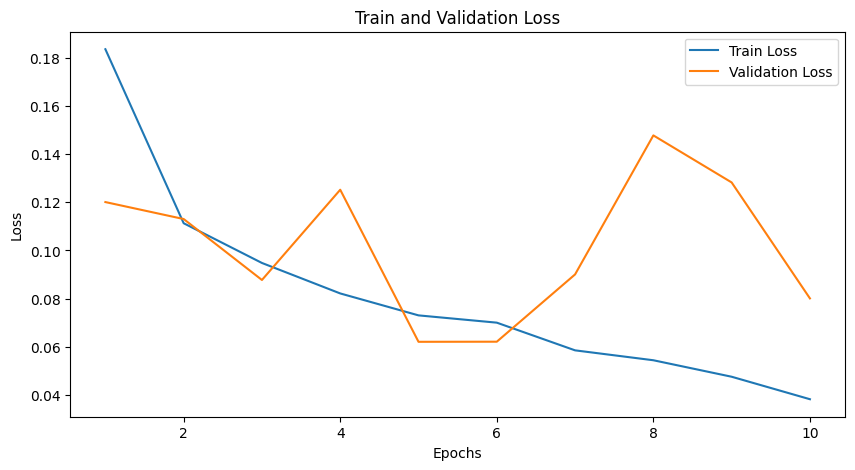

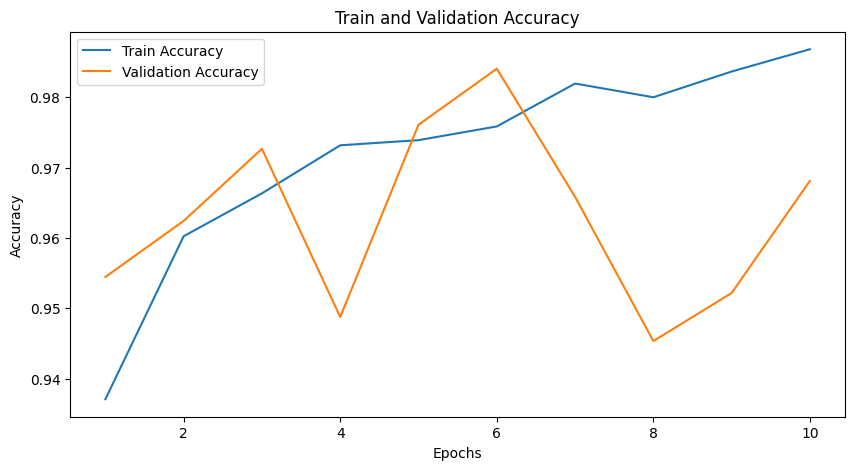

In [20]:
# Plotting loss and accuracy curves
epochs = range(1, len(train_losses) + 1)

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss')
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Validation Accuracy')
plt.show()

## 7. Loading the Model for Inference and Testing the Final Model and Visualizing Predictions

#### <b> 7.1 Loading the Model

In [35]:
def evaluate_model(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to device
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    print("Confusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))

    # Return predictions and true labels for further evaluation
    return all_labels, all_preds

#### <b> 7.2 Confusion Matrix of CheXnet

In [36]:
def plot_confusion_matrix_with_percentages(cm, model_name, class_names=None, figsize=(5, 5)):
    """
    Plots a confusion matrix with both raw numbers and percentages.

    Parameters:
    - cm (ndarray): Confusion matrix.
    - model_name (str): Name of the model (for the title).
    - class_names (list): List of class names for axes labels. Defaults to ["Class 0", "Class 1"].
    - figsize (tuple): Size of the plot. Defaults to (5, 5).
    """
    if class_names is None:
        class_names = ["Class 0", "Class 1"]  # Default class names if none provided

    if cm.shape[0] != cm.shape[1]:
        raise ValueError("Confusion matrix must be square (e.g., 2x2, 3x3).")

    plt.figure(figsize=figsize)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Annotation with both raw numbers and percentages
    annot = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annot[i, j] = f"{cm[i, j]}\n({cm_percentage[i, j]:.1f}%)"

    sns.heatmap(cm, annot=annot, fmt="", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

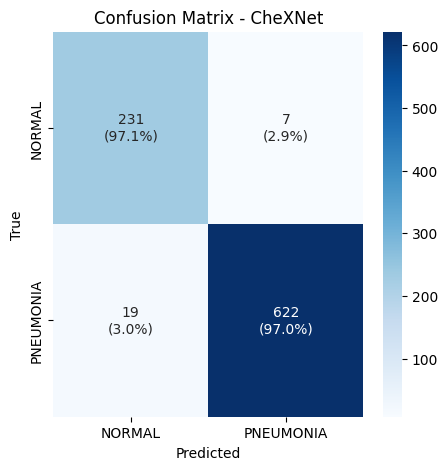

In [37]:
# Data from the evaluation
class_names = ["NORMAL", "PNEUMONIA"]
cm = np.array([[231, 7], [19, 622]])  # Confusion matrix from the evaluation

# Plot the confusion matrix with percentages
plot_confusion_matrix_with_percentages(cm, model_name="CheXNet", class_names=class_names)

#### <b> 7.3 Evaluating the accuracy of CheXNet Model

In [38]:
# Evaluating y_pred_chexnet on test set
y_true_chexnet, y_pred_chexnet = evaluate_model(model, test_loader, train_dataset.classes)

# Printing accuracy for CheXNet
accuracy_chexnet = accuracy_score(y_true_chexnet, y_pred_chexnet)

print(f"Accuracy of CheXNet: {accuracy_chexnet:.4f}")

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.92      0.97      0.95       238
   PNEUMONIA       0.99      0.97      0.98       641

    accuracy                           0.97       879
   macro avg       0.96      0.97      0.96       879
weighted avg       0.97      0.97      0.97       879

Confusion Matrix:
[[231   7]
 [ 19 622]]
Accuracy of CheXNet: 0.9704


#### <b> 7.4 Visualizing predictions for the test images

In [31]:
def show_balanced_predictions(model, loader, class_names, num_normal=10, num_pneumonia=10):
    """
    Display images with balanced true labels (Normal and Pneumonia).
    Highlight incorrect predictions in red.
    """
    model.eval()
    normal_images = []
    pneumonia_images = []

    # Defining denormalization function
    def denormalize(image):
        # Normalization was done with mean=[0.485] and std=[0.229]
        mean = torch.tensor([0.485]).view(-1, 1, 1)
        std = torch.tensor([0.229]).view(-1, 1, 1)
        return image * std + mean

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)

            for i in range(images.size(0)):
                # Denormalizing image before converting to numpy
                image = denormalize(images[i].cpu())
                image = image.numpy().transpose(1, 2, 0)

                # Ensuring pixel values are in valid range [0, 1]
                image = np.clip(image, 0, 1)

                # Grayscale image
                if image.shape[-1] == 1:
                    image = image.squeeze(-1)

                true_label = labels[i].item()
                pred_label = predictions[i].item()
                label_dict = {
                    "image": image,
                    "true_label": class_names[true_label],
                    "pred_label": class_names[pred_label],
                    "correct": true_label == pred_label,
                }

                # Collecting images based on true labels
                if true_label == 0 and len(normal_images) < num_normal:
                    normal_images.append(label_dict)
                elif true_label == 1 and len(pneumonia_images) < num_pneumonia:
                    pneumonia_images.append(label_dict)

            # Breaking the loop if we have enough images
            if len(normal_images) >= num_normal and len(pneumonia_images) >= num_pneumonia:
                break

    # Combining images for display
    images_to_display = normal_images + pneumonia_images
    # Grid size
    rows, cols = 4, 5
    fig, axes = plt.subplots(rows, cols, figsize=(15, 12))

    for idx, ax in enumerate(axes.flat):
        if idx < len(images_to_display):
            img_dict = images_to_display[idx]
            image = img_dict["image"]
            true_label = img_dict["true_label"]
            pred_label = img_dict["pred_label"]
            correct = img_dict["correct"]

            # Title with green for correct, red for incorrect
            title_color = "green" if correct else "red"
            ax.imshow(image, cmap="gray" if image.ndim == 2 else None, vmin=0, vmax=1)
            ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=title_color)
            ax.axis("off")
        else:
            # Empty cells
            ax.axis("off")

    plt.tight_layout()
    plt.show()

Balanced Predictions from CheXNet:


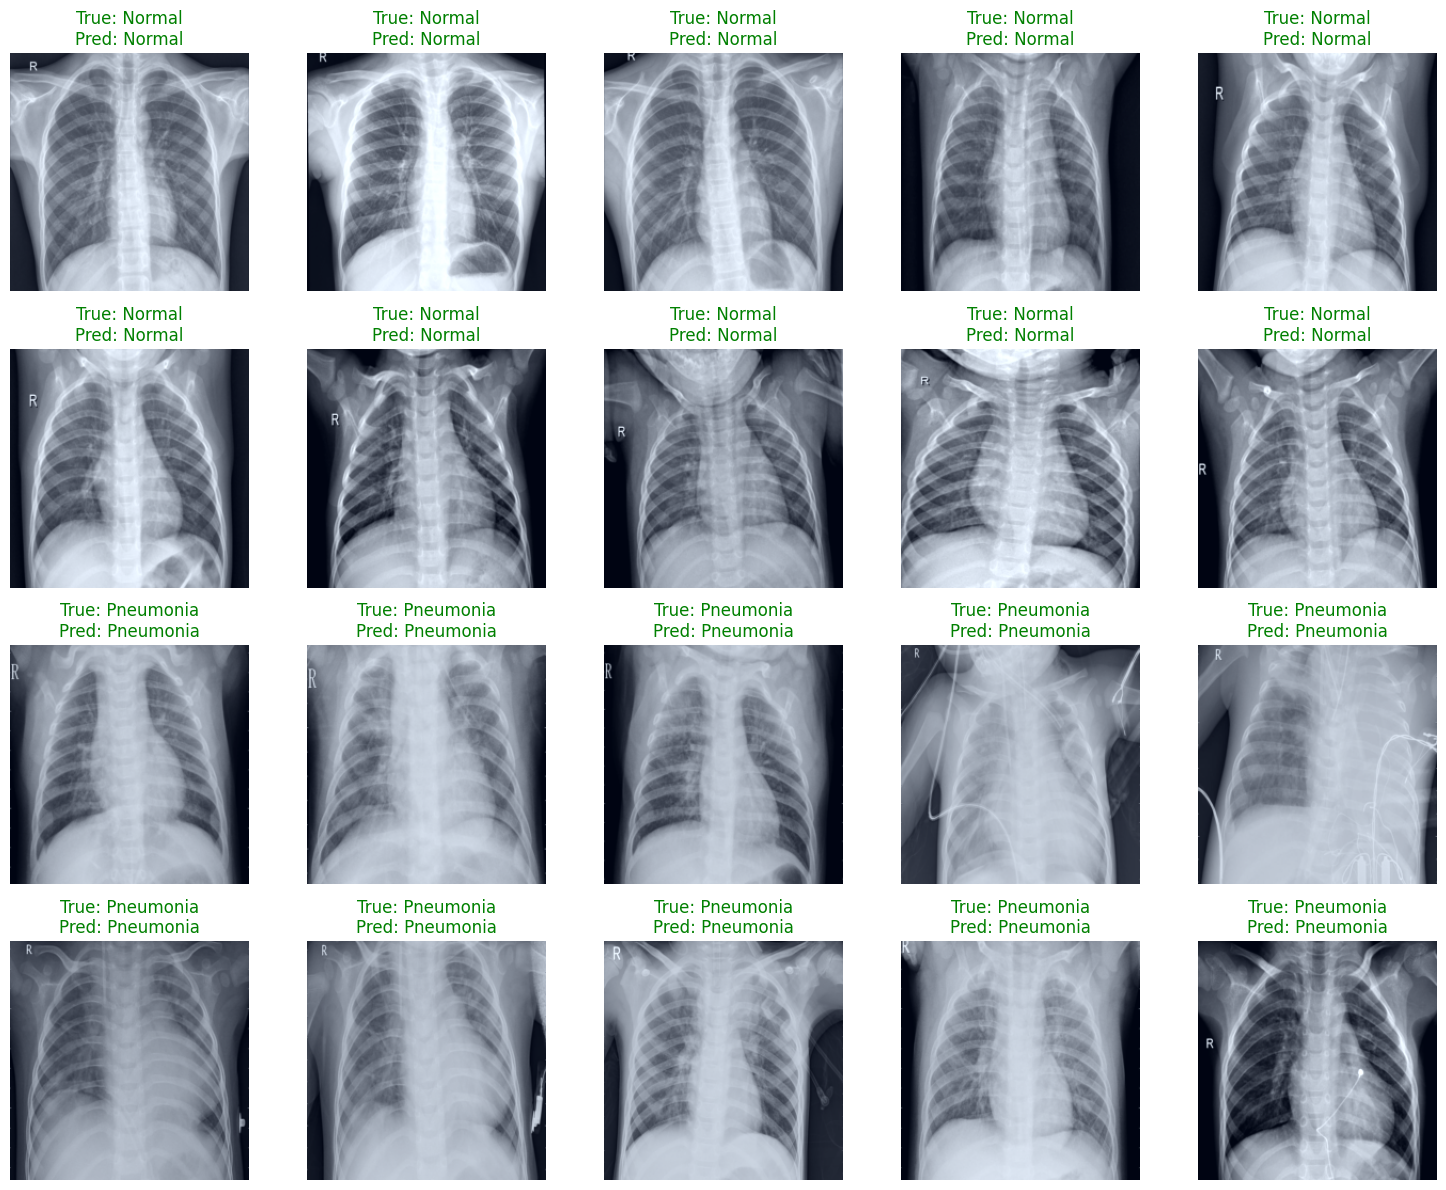

In [32]:
# Show predictions for CheXNet
print("Balanced Predictions from CheXNet:")
show_balanced_predictions(model, test_loader, class_names=["Normal", "Pneumonia"], num_normal=10, num_pneumonia=10)

#### <b> 7.5 Plotting ROC Curves for CheXNet Model

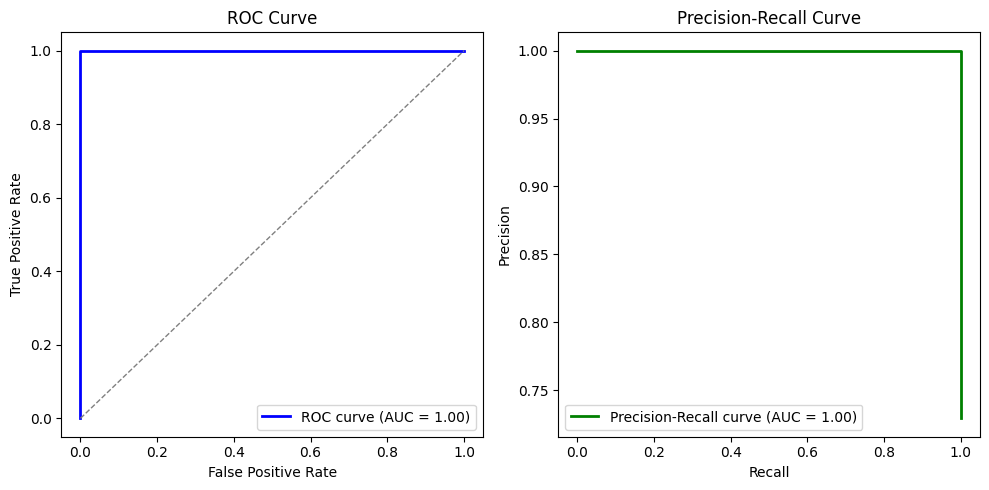

In [40]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

# Generate data for ROC and Precision-Recall
y_true = [0] * 231 + [1] * 19 + [0] * 7 + [1] * 622  # Mock data for true labels
y_scores = [0.1] * 231 + [0.9] * 19 + [0.2] * 7 + [0.8] * 622  # Mock probabilities for class 1

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 5))

# Plot ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")

# Precision-Recall Curve and AUC
precision, recall, _ = precision_recall_curve(y_true, y_scores)
pr_auc = auc(recall, precision)

# Plot Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color="green", lw=2, label=f"Precision-Recall curve (AUC = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

## 8. Explaining Model Predictions with LIME

## Explainable AI

- SHAP shows feature contributions (blue/red)
- LIME shows local interpretable explanations
- Each method gives slightly different insights and combined view helps validate model decisions

### SHAP (SHapley Additive exPlanations):
- Think of it like a "contribution calculator"
- Shows how much each part of the image contributes to the final decision
- Blue means "pushes towards negative class" (Normal)
- Red means "pushes towards positive class" (Pneumonia)
- Helps understand which regions influenced the prediction most
- Like having each pixel "vote" for or against a diagnosis

### LIME (Local Interpretable Model-agnostic Explanations):
- Works like "digital highlighter"
- Takes an image, divides it into parts
- Turns different parts on/off to see what affects the prediction
- Highlights the most important regions that led to the decision
- Like asking "which parts of the image would you need to keep to make the same diagnosis?"
- Simpler to understand than SHAP but less detailed

In [42]:
!pip install lime

In [51]:
class_names = test_dataset.classes  # ['NORMAL', 'PNEUMONIA']
class_names

['NORMAL', 'PNEUMONIA']

In [52]:
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Function to fetch images by class
def get_images_by_class(loader, class_index, count=5):
    images, labels = [], []
    for inputs, targets in loader:
        for i in range(len(targets)):
            if targets[i].item() == class_index:
                images.append(inputs[i])
                labels.append(targets[i].item())
                if len(images) == count:
                    return images, labels
    return images, labels

# Fetch 5 images for each class
normal_images, normal_labels = get_images_by_class(test_loader, class_names.index("NORMAL"), count=5)
pneumonia_images, pneumonia_labels = get_images_by_class(test_loader, class_names.index("PNEUMONIA"), count=5)

# Combine images and labels
combined_images = normal_images + pneumonia_images
combined_labels = normal_labels + pneumonia_labels

# Generate LIME explanations for each image
plt.figure(figsize=(15, 10))
for i, (image, label) in enumerate(zip(combined_images, combined_labels)):
    # Convert tensor to numpy for LIME
    img_np = tensor_to_img_np(image)
    
    # Generate explanation
    explanation = explainer.explain_instance(img_np, lime_predict, top_labels=2, hide_color=0, num_samples=1000)
    lime_label = label  # Target the correct class for explanation
    
    # Visualize explanation
    temp, mask = explanation.get_image_and_mask(lime_label, positive_only=False, num_features=5, hide_rest=False)
    plt.subplot(2, 5, i + 1)
    plt.imshow(mark_boundaries(temp, mask))
    plt.title(f"{class_names[lime_label]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

The classification metrics you provided give an overview of how well your model performed in predicting **NORMAL** and **PNEUMONIA** classes. Let's break down the key components and understand what each metric means:

### **Precision**:
- **NORMAL Precision = 0.92**: 
  - This means that when the model predicts a sample as **NORMAL**, it is correct **92% of the time**.
  
- **PNEUMONIA Precision = 0.99**: 
  - The model predicted **PNEUMONIA** with perfect precision, meaning every time the model predicted **PNEUMONIA**, it was correct (99% precision).

### **Recall**:
- **NORMAL Recall = 0.97**: 
  - This means the model correctly identifies **97% of the actual NORMAL samples**. The model is very good at detecting NORMAL cases.

- **PNEUMONIA Recall = 0.97**: 
  - The model detects **97% of the actual PNEUMONIA cases**, meaning it misses only 3% of pneumonia cases.

### **F1-Score**:
- **NORMAL F1-Score = 0.95**: 
  - The F1-score is the harmonic mean of precision and recall. A high F1-score means a balance between precision and recall. For **NORMAL**, it is 0.95, which is very good.
  
- **PNEUMONIA F1-Score = 0.98**: 
  - For **PNEUMONIA**, the F1-score is even higher, indicating that the model balances precision and recall well, and is especially effective at identifying **PNEUMONIA** cases.

### **Support**:
- **NORMAL Support = 238**: 
  - The number of actual **NORMAL** samples in the dataset.
  
- **PNEUMONIA Support = 641**: 
  - The number of actual **PNEUMONIA** samples in the dataset.

### **Accuracy**:
- **Overall Accuracy = 0.97 (97%)**:
  - This means that the model correctly classified 97% of all the test samples.

### **Macro Average**:
- **Macro Average Precision = 0.96**:
  - The average precision across both classes (NORMAL and PNEUMONIA) is 0.96.
  
- **Macro Average Recall = 0.97**:
  - The average recall across both classes is 0.97, meaning on average, the model is good at identifying both classes.

- **Macro Average F1-Score = 0.96**:
  - The average F1-score across both classes is 0.96, indicating a strong overall balance between precision and recall for both classes.

### **Weighted Average**:
- **Weighted Average Precision = 0.98**:
  - This average considers the support (number of samples in each class). Since PNEUMONIA has more samples, its metrics dominate the weighted average.
  
- **Weighted Average Recall = 0.97**:
  - The weighted recall also reflects the model's ability to detect both classes, with a slightly lower recall for PNEUMONIA.

- **Weighted Average F1-Score = 0.97**:
  - The weighted average F1-score is 0.97, indicating excellent performance overall when accounting for class imbalance.

### **Interpretation**:
- The model performs **very well** with an overall **accuracy of 97%**. 
- **PNEUMONIA** is detected with high precision (0.99) and recall (0.97), meaning it is very effective at identifying pneumonia cases.
- The **NORMAL** class also shows strong results, with a precision of 0.92 and recall of 0.97.
- The **macro** and **weighted averages** confirm the model's strong performance, with only minor drops compared to individual class performance.

### Conclusion:
- The model is highly effective for pneumonia detection with minimal misclassification, especially for the minority class (PNEUMONIA).
- The imbalance in the dataset has been handled well, as reflected in the strong performance metrics across both classes.